In [1]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import numpy as np

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
torch.__version__

'1.9.1'

In [4]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3), value=(125,122,114), inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [7]:
# Training

def train(epoch, net, criterion, trainloader,scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    beta = 1
    cutmix_prob = 1
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        r = np.random.rand(1)
        
        if beta > 0 and r < cutmix_prob:
            # generate mixed sample
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(inputs.size()[0]).cuda()
            target_a = targets
            target_b = targets[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            # compute output
            outputs = net(inputs)
            loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
        else:
            # compute output
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        #outputs = net(inputs)
        #loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
            print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

In [8]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)

            loss= criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [9]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [10]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [11]:
# main body
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4
}

train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list  = []


net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
#print(scheduler)
for epoch in range(0, 200):
    # normal - train, jaco- jaco_train
    train_loss, train_acc = train(epoch, net, criterion, trainloader,scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    


Epoch: 0


<ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more detai

iteration :  50, loss : 2.1604, accuracy : 20.09
iteration : 100, loss : 2.1222, accuracy : 22.63
iteration : 150, loss : 2.0871, accuracy : 24.71
iteration : 200, loss : 2.0456, accuracy : 26.51
iteration : 250, loss : 2.0145, accuracy : 27.87
iteration : 300, loss : 1.9844, accuracy : 29.26
iteration : 350, loss : 1.9477, accuracy : 31.05
Epoch :   0, training loss : 1.9326, training accuracy : 31.82, test loss : 1.3525, test accuracy : 50.52

Epoch: 1
iteration :  50, loss : 1.8020, accuracy : 37.53
iteration : 100, loss : 1.7676, accuracy : 39.32
iteration : 150, loss : 1.7527, accuracy : 39.95
iteration : 200, loss : 1.7531, accuracy : 40.07
iteration : 250, loss : 1.7355, accuracy : 41.03
iteration : 300, loss : 1.7151, accuracy : 42.10
iteration : 350, loss : 1.7044, accuracy : 42.52
Epoch :   1, training loss : 1.7014, training accuracy : 42.52, test loss : 1.0973, test accuracy : 62.19

Epoch: 2
iteration :  50, loss : 1.5965, accuracy : 45.17
iteration : 100, loss : 1.6338, a

iteration :  50, loss : 1.1363, accuracy : 60.83
iteration : 100, loss : 1.1405, accuracy : 64.30
iteration : 150, loss : 1.1239, accuracy : 64.81
iteration : 200, loss : 1.1235, accuracy : 64.96
iteration : 250, loss : 1.1256, accuracy : 65.50
iteration : 300, loss : 1.1143, accuracy : 65.81
iteration : 350, loss : 1.1219, accuracy : 65.36
Epoch :  18, training loss : 1.1256, training accuracy : 65.01, test loss : 0.5425, test accuracy : 84.01

Epoch: 19
iteration :  50, loss : 1.1240, accuracy : 65.36
iteration : 100, loss : 1.0779, accuracy : 68.04
iteration : 150, loss : 1.0688, accuracy : 68.71
iteration : 200, loss : 1.1099, accuracy : 66.84
iteration : 250, loss : 1.1317, accuracy : 66.07
iteration : 300, loss : 1.1244, accuracy : 66.37
iteration : 350, loss : 1.1166, accuracy : 66.65
Epoch :  19, training loss : 1.1169, training accuracy : 66.41, test loss : 0.4795, test accuracy : 85.78

Epoch: 20
iteration :  50, loss : 1.1084, accuracy : 70.12
iteration : 100, loss : 1.1176,

iteration :  50, loss : 1.0285, accuracy : 69.81
iteration : 100, loss : 1.0470, accuracy : 68.48
iteration : 150, loss : 1.0134, accuracy : 70.08
iteration : 200, loss : 0.9994, accuracy : 69.37
iteration : 250, loss : 1.0071, accuracy : 69.42
iteration : 300, loss : 1.0028, accuracy : 69.80
iteration : 350, loss : 1.0036, accuracy : 69.56
Epoch :  36, training loss : 0.9947, training accuracy : 70.30, test loss : 0.3611, test accuracy : 89.17

Epoch: 37
iteration :  50, loss : 0.9558, accuracy : 73.09
iteration : 100, loss : 1.0026, accuracy : 71.66
iteration : 150, loss : 1.0027, accuracy : 69.43
iteration : 200, loss : 1.0012, accuracy : 70.84
iteration : 250, loss : 1.0034, accuracy : 70.73
iteration : 300, loss : 1.0043, accuracy : 70.92
iteration : 350, loss : 1.0059, accuracy : 70.95
Epoch :  37, training loss : 1.0055, training accuracy : 70.67, test loss : 0.3525, test accuracy : 90.59

Epoch: 38
iteration :  50, loss : 1.0023, accuracy : 69.97
iteration : 100, loss : 0.9806,

iteration :  50, loss : 0.8977, accuracy : 72.78
iteration : 100, loss : 0.9014, accuracy : 71.77
iteration : 150, loss : 0.8908, accuracy : 73.33
iteration : 200, loss : 0.9026, accuracy : 72.97
iteration : 250, loss : 0.9092, accuracy : 73.63
iteration : 300, loss : 0.9067, accuracy : 73.62
iteration : 350, loss : 0.9051, accuracy : 73.65
Epoch :  54, training loss : 0.9134, training accuracy : 73.45, test loss : 0.3279, test accuracy : 91.00

Epoch: 55
iteration :  50, loss : 0.9114, accuracy : 68.83
iteration : 100, loss : 0.8857, accuracy : 71.18
iteration : 150, loss : 0.8847, accuracy : 71.68
iteration : 200, loss : 0.8926, accuracy : 72.95
iteration : 250, loss : 0.8834, accuracy : 74.39
iteration : 300, loss : 0.8824, accuracy : 74.17
iteration : 350, loss : 0.8862, accuracy : 73.50
Epoch :  55, training loss : 0.8856, training accuracy : 73.95, test loss : 0.2996, test accuracy : 92.30

Epoch: 56
iteration :  50, loss : 0.8647, accuracy : 70.97
iteration : 100, loss : 0.8913,

iteration :  50, loss : 0.7172, accuracy : 87.61
iteration : 100, loss : 0.7921, accuracy : 80.58
iteration : 150, loss : 0.8235, accuracy : 78.48
iteration : 200, loss : 0.8372, accuracy : 77.00
iteration : 250, loss : 0.8389, accuracy : 77.78
iteration : 300, loss : 0.8370, accuracy : 77.80
iteration : 350, loss : 0.8360, accuracy : 77.68
Epoch :  72, training loss : 0.8391, training accuracy : 77.33, test loss : 0.2535, test accuracy : 92.74

Epoch: 73
iteration :  50, loss : 0.8270, accuracy : 79.22
iteration : 100, loss : 0.8684, accuracy : 75.90
iteration : 150, loss : 0.8688, accuracy : 74.33
iteration : 200, loss : 0.8761, accuracy : 74.15
iteration : 250, loss : 0.8797, accuracy : 74.32
iteration : 300, loss : 0.8789, accuracy : 73.98
iteration : 350, loss : 0.8760, accuracy : 74.07
Epoch :  73, training loss : 0.8666, training accuracy : 74.77, test loss : 0.2465, test accuracy : 93.02

Epoch: 74
iteration :  50, loss : 0.8408, accuracy : 76.92
iteration : 100, loss : 0.8508,

iteration :  50, loss : 0.8058, accuracy : 70.69
iteration : 100, loss : 0.7965, accuracy : 73.79
iteration : 150, loss : 0.7959, accuracy : 72.71
iteration : 200, loss : 0.8045, accuracy : 73.53
iteration : 250, loss : 0.7991, accuracy : 74.22
iteration : 300, loss : 0.7937, accuracy : 74.68
iteration : 350, loss : 0.7873, accuracy : 75.42
Epoch :  90, training loss : 0.7867, training accuracy : 76.03, test loss : 0.2248, test accuracy : 93.57

Epoch: 91
iteration :  50, loss : 0.7679, accuracy : 81.62
iteration : 100, loss : 0.8233, accuracy : 77.94
iteration : 150, loss : 0.8223, accuracy : 77.69
iteration : 200, loss : 0.8214, accuracy : 77.68
iteration : 250, loss : 0.8276, accuracy : 77.74
iteration : 300, loss : 0.8354, accuracy : 77.50
iteration : 350, loss : 0.8275, accuracy : 77.10
Epoch :  91, training loss : 0.8206, training accuracy : 77.08, test loss : 0.2295, test accuracy : 93.37

Epoch: 92
iteration :  50, loss : 0.8193, accuracy : 76.55
iteration : 100, loss : 0.7851,

iteration :  50, loss : 0.7461, accuracy : 81.44
iteration : 100, loss : 0.7309, accuracy : 83.80
iteration : 150, loss : 0.7382, accuracy : 81.79
iteration : 200, loss : 0.7510, accuracy : 81.05
iteration : 250, loss : 0.7495, accuracy : 81.35
iteration : 300, loss : 0.7519, accuracy : 81.19
iteration : 350, loss : 0.7493, accuracy : 80.87
Epoch : 108, training loss : 0.7494, training accuracy : 80.40, test loss : 0.2251, test accuracy : 93.20

Epoch: 109
iteration :  50, loss : 0.7713, accuracy : 80.84
iteration : 100, loss : 0.7528, accuracy : 80.00
iteration : 150, loss : 0.7719, accuracy : 78.83
iteration : 200, loss : 0.7639, accuracy : 80.04
iteration : 250, loss : 0.7629, accuracy : 80.39
iteration : 300, loss : 0.7687, accuracy : 80.69
iteration : 350, loss : 0.7670, accuracy : 80.04
Epoch : 109, training loss : 0.7594, training accuracy : 79.90, test loss : 0.2016, test accuracy : 94.05

Epoch: 110
iteration :  50, loss : 0.6998, accuracy : 80.81
iteration : 100, loss : 0.742

iteration :  50, loss : 0.7527, accuracy : 74.70
iteration : 100, loss : 0.7326, accuracy : 77.47
iteration : 150, loss : 0.7442, accuracy : 77.80
iteration : 200, loss : 0.7336, accuracy : 78.27
iteration : 250, loss : 0.7324, accuracy : 77.47
iteration : 300, loss : 0.7387, accuracy : 76.57
iteration : 350, loss : 0.7227, accuracy : 77.78
Epoch : 126, training loss : 0.7295, training accuracy : 78.08, test loss : 0.1840, test accuracy : 94.63

Epoch: 127
iteration :  50, loss : 0.7172, accuracy : 80.55
iteration : 100, loss : 0.7110, accuracy : 82.03
iteration : 150, loss : 0.7165, accuracy : 80.09
iteration : 200, loss : 0.7140, accuracy : 80.12
iteration : 250, loss : 0.7174, accuracy : 79.49
iteration : 300, loss : 0.7105, accuracy : 79.91
iteration : 350, loss : 0.7189, accuracy : 79.17
Epoch : 127, training loss : 0.7211, training accuracy : 79.14, test loss : 0.1976, test accuracy : 94.38

Epoch: 128
iteration :  50, loss : 0.7671, accuracy : 79.70
iteration : 100, loss : 0.756

iteration :  50, loss : 0.6405, accuracy : 88.17
iteration : 100, loss : 0.6792, accuracy : 83.85
iteration : 150, loss : 0.7037, accuracy : 80.80
iteration : 200, loss : 0.6998, accuracy : 79.91
iteration : 250, loss : 0.6915, accuracy : 81.42
iteration : 300, loss : 0.6916, accuracy : 81.98
iteration : 350, loss : 0.6904, accuracy : 81.60
Epoch : 144, training loss : 0.6869, training accuracy : 81.79, test loss : 0.1800, test accuracy : 95.12

Epoch: 145
iteration :  50, loss : 0.6977, accuracy : 84.62
iteration : 100, loss : 0.6877, accuracy : 84.72
iteration : 150, loss : 0.6968, accuracy : 83.17
iteration : 200, loss : 0.6920, accuracy : 82.92
iteration : 250, loss : 0.6884, accuracy : 83.27
iteration : 300, loss : 0.6862, accuracy : 82.85
iteration : 350, loss : 0.6829, accuracy : 83.38
Epoch : 145, training loss : 0.6804, training accuracy : 83.56, test loss : 0.1706, test accuracy : 95.32

Epoch: 146
iteration :  50, loss : 0.6876, accuracy : 84.31
iteration : 100, loss : 0.693

iteration :  50, loss : 0.6665, accuracy : 81.34
iteration : 100, loss : 0.6749, accuracy : 76.52
iteration : 150, loss : 0.6780, accuracy : 79.74
iteration : 200, loss : 0.6862, accuracy : 79.42
iteration : 250, loss : 0.6836, accuracy : 80.56
iteration : 300, loss : 0.6879, accuracy : 80.20
iteration : 350, loss : 0.6833, accuracy : 80.28
Epoch : 162, training loss : 0.6810, training accuracy : 80.20, test loss : 0.1646, test accuracy : 95.63

Epoch: 163
iteration :  50, loss : 0.6646, accuracy : 83.84
iteration : 100, loss : 0.6413, accuracy : 82.88
iteration : 150, loss : 0.6370, accuracy : 82.90
iteration : 200, loss : 0.6519, accuracy : 83.24
iteration : 250, loss : 0.6614, accuracy : 83.31
iteration : 300, loss : 0.6529, accuracy : 83.14
iteration : 350, loss : 0.6480, accuracy : 83.09
Epoch : 163, training loss : 0.6552, training accuracy : 82.07, test loss : 0.1734, test accuracy : 95.16

Epoch: 164
iteration :  50, loss : 0.6801, accuracy : 84.89
iteration : 100, loss : 0.674

iteration :  50, loss : 0.6094, accuracy : 85.53
iteration : 100, loss : 0.6125, accuracy : 86.65
iteration : 150, loss : 0.6071, accuracy : 86.35
iteration : 200, loss : 0.6309, accuracy : 83.26
iteration : 250, loss : 0.6376, accuracy : 83.01
iteration : 300, loss : 0.6333, accuracy : 83.75
iteration : 350, loss : 0.6357, accuracy : 83.91
Epoch : 180, training loss : 0.6329, training accuracy : 84.06, test loss : 0.1629, test accuracy : 95.52

Epoch: 181
iteration :  50, loss : 0.6363, accuracy : 83.38
iteration : 100, loss : 0.6684, accuracy : 83.62
iteration : 150, loss : 0.6696, accuracy : 83.14
iteration : 200, loss : 0.6612, accuracy : 83.70
iteration : 250, loss : 0.6579, accuracy : 83.04
iteration : 300, loss : 0.6610, accuracy : 82.90
iteration : 350, loss : 0.6547, accuracy : 82.58
Epoch : 181, training loss : 0.6555, training accuracy : 82.95, test loss : 0.1597, test accuracy : 95.58

Epoch: 182
iteration :  50, loss : 0.6613, accuracy : 82.66
iteration : 100, loss : 0.642

iteration :  50, loss : 0.6167, accuracy : 83.78
iteration : 100, loss : 0.5877, accuracy : 85.17
iteration : 150, loss : 0.5957, accuracy : 86.29
iteration : 200, loss : 0.6062, accuracy : 84.93
iteration : 250, loss : 0.6050, accuracy : 85.28
iteration : 300, loss : 0.6065, accuracy : 86.06
iteration : 350, loss : 0.6226, accuracy : 84.01
Epoch : 198, training loss : 0.6253, training accuracy : 83.95, test loss : 0.1581, test accuracy : 95.67

Epoch: 199
iteration :  50, loss : 0.6344, accuracy : 83.72
iteration : 100, loss : 0.6192, accuracy : 83.70
iteration : 150, loss : 0.6346, accuracy : 84.33
iteration : 200, loss : 0.6419, accuracy : 84.39
iteration : 250, loss : 0.6421, accuracy : 84.14
iteration : 300, loss : 0.6337, accuracy : 84.25
iteration : 350, loss : 0.6452, accuracy : 82.23
Epoch : 199, training loss : 0.6408, training accuracy : 82.95, test loss : 0.1605, test accuracy : 95.59


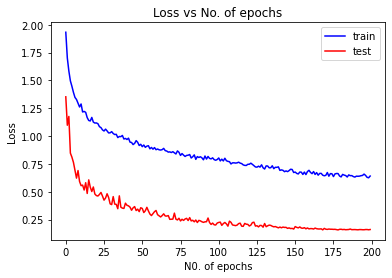

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')

plt.xlabel("N0. of epochs")
plt.ylabel("Loss")
plt.title("Loss vs No. of epochs")
plt.legend(['train', 'test'])
plt.show()

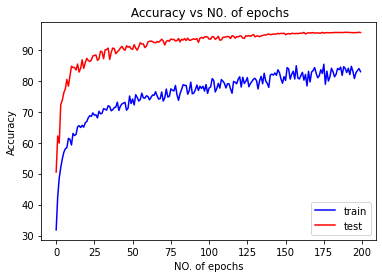

In [13]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("NO. of epochs")
plt.ylabel("Accuracy")
plt.title(" Accuracy vs N0. of epochs")
plt.legend(['train', 'test']) 
plt.show()